In [ ]:
!pip install mxnet-cu101mkl gluoncv d2l

In [2]:
from d2l import mxnet as d2l
from mxnet import np, npx
from mxnet.gluon import nn
npx.set_np()
class Inception(nn.Block):
  # `c1`--`c4` are the number of output channels for each path
  def __init__(self, c1, c2, c3, c4, **kwargs):
    super(Inception, self).__init__(**kwargs)
    # Path 1 is a single 1 x 1 convolutional layer
    self.p1_1 = nn.Conv2D(c1, kernel_size=1, activation='relu')
    # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
    # convolutional layer
    self.p2_1 = nn.Conv2D(c2[0], kernel_size=1, activation='relu')
    self.p2_2 = nn.Conv2D(c2[1], kernel_size=3, padding=1, activation='relu')
    # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
    # convolutional layer
    self.p3_1 = nn.Conv2D(c3[0], kernel_size=1, activation='relu')
    self.p3_2 = nn.Conv2D(c3[1], kernel_size=5, padding=2, activation='relu')
    # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
    # convolutional layer
    self.p4_1 = nn.MaxPool2D(pool_size=3, strides=1, padding=1)
    self.p4_2 = nn.Conv2D(c4, kernel_size=1, activation='relu')
  def forward(self, x):
    p1 = self.p1_1(x)
    p2 = self.p2_2(self.p2_1(x))
    p3 = self.p3_2(self.p3_1(x))
    p4 = self.p4_2(self.p4_1(x))
    # Concatenate the outputs on the channel dimension
    return np.concatenate((p1, p2, p3, p4), axis=1)

In [3]:
b1 = nn.Sequential()
b1.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3, activation='relu'),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

In [4]:
b2 = nn.Sequential()
b2.add(nn.Conv2D(64, kernel_size=1, activation='relu'),
       nn.Conv2D(192, kernel_size=3, padding=1, activation='relu'),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

In [5]:
b3 = nn.Sequential()
b3.add(Inception(64, (96, 128), (16, 32), 32),
       Inception(128, (128, 192), (32, 96), 64),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

In [6]:
b4 = nn.Sequential()
b4.add(Inception(192, (96, 208), (16, 48), 64),
       Inception(160, (112, 224), (24, 64), 64),
       Inception(128, (128, 256), (24, 64), 64),
       Inception(112, (144, 288), (32, 64), 64),
       Inception(256, (160, 320), (32, 128), 128),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

In [8]:
b5 = nn.Sequential()
b5.add(Inception(256, (160, 320), (32, 128), 128),
       Inception(384, (192, 384), (48, 128), 128),
       nn.GlobalAvgPool2D())
net = nn.Sequential()
net.add(b1, b2, b3, b4, b5, nn.Dense(10))

In [9]:
X = np.random.uniform(size=(1, 1, 96, 96))
net.initialize()
for layer in net:
  X = layer(X)
  print(layer.name, 'output shape:\t', X.shape)

sequential0 output shape:	 (1, 64, 24, 24)
sequential1 output shape:	 (1, 192, 12, 12)
sequential2 output shape:	 (1, 480, 6, 6)
sequential3 output shape:	 (1, 832, 3, 3)
sequential4 output shape:	 (1, 1024, 1, 1)
dense0 output shape:	 (1, 10)


loss 0.242, train acc 0.908, test acc 0.892
1181.3 examples/sec on gpu(0)


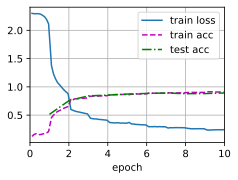

In [10]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)